# RGI13 (Central Asia)

F. Maussion & S. Galos.

GAMDAM v2

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import (mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist, 
                   find_duplicates, open_zip_shapefile, correct_geoms, fix_overaps)
import os

### specify RGI-region and storage paths

In [2]:
# Region of interest
reg = 13

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '13_rgi60_CentralAsia.zip')

# Region is based on GAMDAM, use for comparison
support_dir = os.path.join(data_dir, 'l0_support_data')
gamdam_dir = os.path.join(support_dir, 'gamdam')

### Load the input data

In [3]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [4]:
sdf, _ = submission_summary(shp)
sdf

N        A                                           analysts  \
subm_id                                                                      
26          20      8.5                                            Nosenko   
27          30     88.8                                            Nosenko   
28          19     18.5                                            Nosenko   
29           4      5.1                                           Khromova   
30          25     19.5                                           Khromova   
...        ...      ...                                                ...   
605       1399   3181.8                              Bhambri, Bolch, Moelg   
610         44     12.8                              Bhambri, Bolch, Moelg   
637      54409  49241.0  Bolch, Cogley, Frey, Guo, Liu, Moelg, Nuimura,...   
638          8      8.1  Bolch, Cogley, Frey, Guo, Liu, Nuimura, Paul, ...   
752      75614  50344.0                                              Sakai   

        submitters  release_date  \
subm_id                            
26        Khromova          2005   
27        Khromova          2005   
28        Khromova          2005   
29        Khromova          2005   
30        Khromova          2005   
...            ...           ...   
605        Bhambri          2013   
610        Bhambri          2013   
637         Cogley          2015   
638         Cogley          2015   
752          Sakai          2018   

                                                 geog_area  src_date_mode  \
subm_id                                                                     
26                                      Siberian Mountains           2002   
27                                      Siberian Mountains           2002   
28                                      Siberian Mountains           2002   
29                                      Siberian Mountains           2002   
30                                      Siberian Mountains           2002   
...                                                    ...            ...   
605                                            Khumbu Area           2000   
610                                            Khumbu Area           2001   
637      Randolph Glacier Inventory; Umbrella RC for me...           2009   
638      Randolph Glacier Inventory; Umbrella RC for me...           2002   
752                                                   Asia           2002   

         src_date_min  src_date_max  
subm_id                              
26               2002          2002  
27               2002          2002  
28               2002          2002  
29               2002          2002  
30               2002          2002  
...               ...           ...  
605              2000          2000  
610              2001          2001  
637              1998          2013  
638              2002          2009  
752              1989          2013  

[128 rows x 9 columns]

In [5]:
# # Optional: write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_inventories']))

## Outline selection 

### Apply selection criteria to create the RGI-07 data subset

In [6]:
# try to get the data relevant for RGI07 and select by attributes
rgi7 = shp.loc[shp['subm_id'] == 752].copy()
rgi7['is_rgi6'] = False

In [7]:
# Size filter?
needs_size_filter(rgi7)

True

### Some sanity checks 

In [8]:
dupes = find_duplicates(rgi7)

Seems Okay!


In [9]:
rgi7 = correct_geoms(rgi7)

Found 11 invalid geometries out of 75614.
After correction, 0 geometries are still invalid.
Area changed by -0.6 m2 (-0.0000%, or 0 tiny glaciers)


In [10]:
rgi7 = fix_overaps(rgi7)

Finding intersecting geometries
Computing overlap of intersecting pairs
Found 1177 overlaps out of 75614. Correcting...
After correction, Area changed by -21364.8 m2 (-0.0000%, or -2 tiny glaciers)
Final check...
Finding intersecting geometries
Computing overlap of intersecting pairs
OK! Check done


In [11]:
rgi7 = correct_geoms(rgi7)

Found 0 invalid geometries out of 75614.


In [12]:
print(len(rgi7))
rgi7 = size_filter(rgi7)
print(len(rgi7))

75614
75613


In [13]:
sdf, df_class = submission_summary(rgi7)
df_class

N   N NA
subm_id              
752      75613  75613

In [14]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    check = np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())
    if np.any(check):
        print(f'Orphan rock outcrops detected in subm_id {rgi7.subm_id.unique()[check]}')
        orphan_f['area'] = orphan_f.to_crs({'proj':'cea'}).area

### Plots 

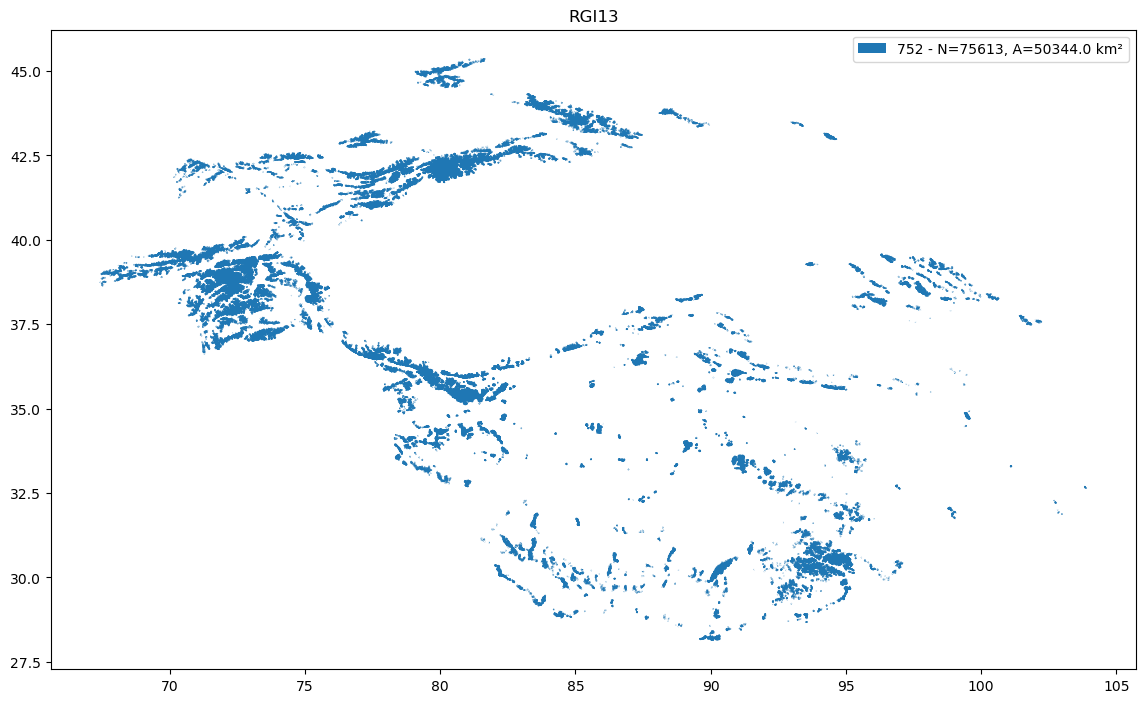

In [15]:
plot_map(rgi7, reg)

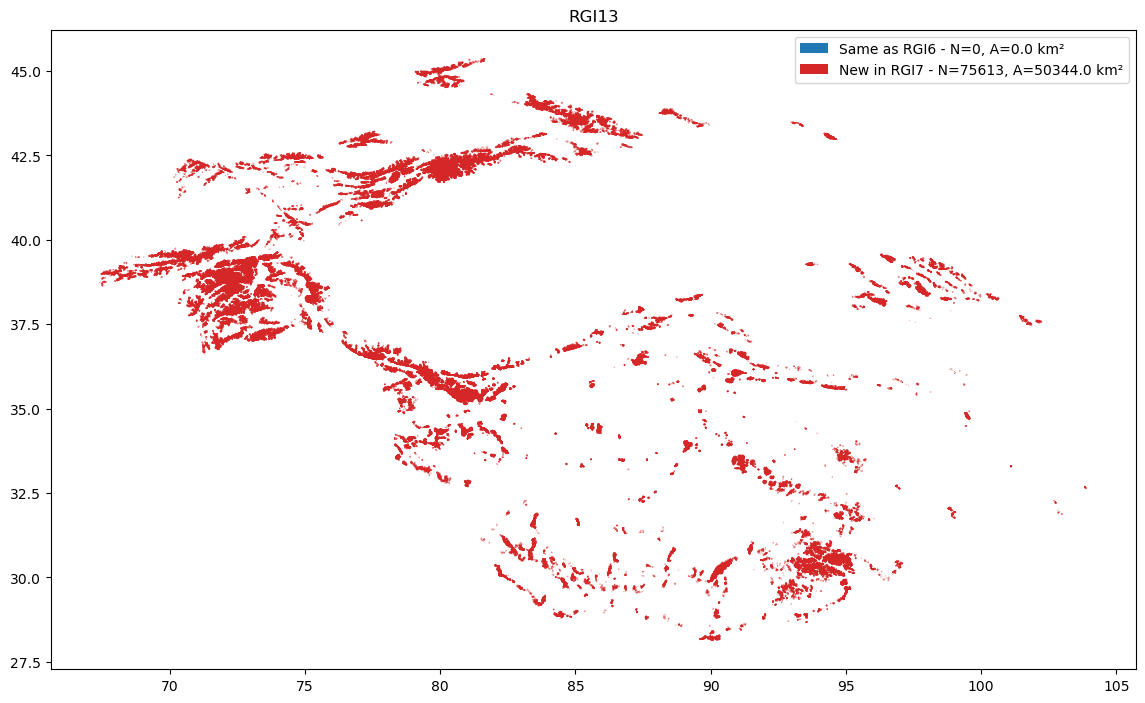

In [16]:
plot_map(rgi7, reg, is_rgi6=True)

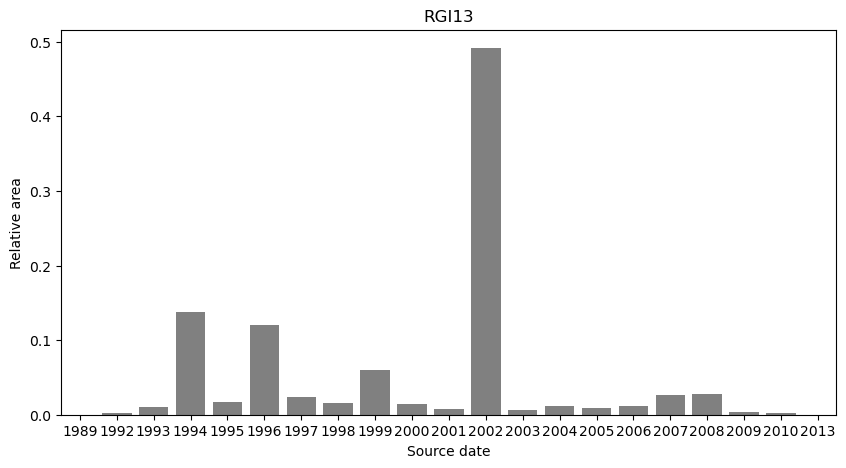

In [17]:
plot_date_hist(rgi7, reg)

### Text for github

In [18]:
fgh = sdf.T
fgh

subm_id            752
N                75613
A              50344.0
analysts         Sakai
submitters       Sakai
release_date      2018
geog_area         Asia
src_date_mode     2002
src_date_min      1989
src_date_max      2013

In [19]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 752     |
|:--------------|:--------|
| N             | 75613   |
| A             | 50344.0 |
| analysts      | Sakai   |
| submitters    | Sakai   |
| release_date  | 2018    |
| geog_area     | Asia    |
| src_date_mode | 2002    |
| src_date_min  | 1989    |
| src_date_max  | 2013    |


## Write out and tar 

In [20]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
RGI13/
RGI13/RGI13.shx
RGI13/RGI13.cpg
RGI13/RGI13.prj
RGI13/RGI13.shp
RGI13/RGI13.dbf
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI13.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI13'], returncode=0)


## New RGI-file created - Check result!

load reference data (here GAMDAM original) to enable comparison

In [ ]:
# Region file to select from gamdam
reg_file = os.path.join(data_dir, '00_rgi70_regions', '00_rgi70_O1Regions', '00_rgi70_O1Regions.shp')

In [ ]:
# specify path to reference data set
import glob
from utils import open_zip_shapefile
gam_files = glob.glob(gamdam_dir + '/*.zip')
df_ref = []
for gf in gam_files:
    df_ref.append(open_zip_shapefile(gf))

df_ref = pd.concat(df_ref).reset_index()

In [ ]:
# Calculate representative points for reference data
ref_rp = df_ref.representative_point()

# Make a dataframe out of it and add the original index to recover it later
ref_rp = ref_rp.to_frame('geometry')
ref_rp['orig_index'] = df_ref.index

# Read region file
reg_f = gpd.read_file(reg_file)

# Make the overlay with the RGI region of interest -> get the rep. points which are located inside the region boundaries
ref_intersect = gpd.overlay(ref_rp, reg_f.loc[reg_f.RGI_CODE == f'{reg:02d}'], how='intersection')

# Now select the entries which intersect from the original shape file (-> extract the polygons) 
df_ref = df_ref.loc[ref_intersect['orig_index'].values].copy()

### Number of elements (differences do depict problems)

In [ ]:
print('Number of glaciers in new RGI subset:', len(rgi7))
print('Number of glaciers in reference data:', len(df_ref) - len(to_remove))
print('Difference:', len(rgi7)-len(df_ref) + len(to_remove))

In [ ]:
refdup = find_duplicates(df_ref)

### Total area

In [ ]:
# add an area field to the selected GAMDAM table
df_ref['area'] = df_ref.to_crs({'proj':'cea'}).area

In [ ]:
# print and compare area values
Area_RGI = rgi7['area'].sum() * 1e-6
print('Area RGI [km²]:', Area_RGI)
Area_ref = df_ref['area'].sum() * 1e-6  - to_remove['area'].sum() * 1e-6
print('Area Ref [km²]:', Area_ref)
d = (Area_RGI - Area_ref)
print('Area difference [km²]:',d)

**I'm not sure why this is - but it doesn't look important**

## Find missing glaciers 

In [ ]:
from utils import haversine
import progressbar

In [ ]:
def xy_coord(geom):
    """To compute CenLon CenLat ourselves"""
    x, y = geom.xy
    return x[0], y[0]

In [ ]:
# compute CenLon CenLat ourselves
rp = df_ref.representative_point()

coordinates = np.array(list(rp.apply(xy_coord)))
df_ref['CenLon'] = coordinates[:, 0]
df_ref['CenLat'] = coordinates[:, 1]

In [ ]:
df_ref_orig = df_ref.copy()

In [ ]:
# Loop over all RGI7 glaciers and find their equivalent in ref
df_ref = df_ref_orig.copy()
not_found = {}
to_drop = []
for i, (ref_area, lon, lat) in progressbar.progressbar(enumerate(zip(rgi7['area'].values, rgi7.CenLon.values, rgi7.CenLat.values)), max_value=len(rgi7)):
#     dist = haversine(lon, lat, df_ref.CenLon.values, df_ref.CenLat.values)
    dist = (lon - df_ref.CenLon.values)**2 + (lat - df_ref.CenLat.values)**2 
    found = False
    for j in np.argsort(dist)[:10]:
        s6 = df_ref.iloc[j]
        if np.allclose(s6['area'], ref_area, rtol=0.001):
            found = True
            to_drop.append(s6.name)
            break
    if not found:
        not_found[i] = df_ref.iloc[np.argsort(dist)[:10]]
    if len(to_drop) > 1000:
        df_ref.drop(labels=to_drop, inplace=True)
        to_drop = []
df_ref.drop(labels=to_drop, inplace=True)

In [ ]:
print(len(not_found), len(df_ref))

In [ ]:
pb_rgi7 = rgi7.iloc[list(not_found.keys())]

In [ ]:
for i, k in enumerate(not_found.keys()):
    ax = rgi7.iloc[[k]].plot(edgecolor='k');
    if i > 3:
        break

In [ ]:
# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_problem_glaciers'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_problem_glaciers_tar'))

dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
pb_rgi7.to_file(dd + f'RGI{reg:02d}_glims.shp')
df_ref.to_file(dd + f'RGI{reg:02d}_ref.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))